In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii
from matplotlib.patches import Rectangle

In [2]:
def F_nu(t_p,nu_p,F_nup,nu_sed):
    '''Calculates a Synchrotron Self-Absorbed Spectrum for given input parameters.
     axs
    Parameters:
    t_p (days): Time of SSA peak - should be single number
    nu_p (GHz): Frequency of SSA peak - should be single number
    F_nup (mJy): Flux of SSA peak - should be single number
    nu (GHz): Frequencies at which you want the SSA spectrum to be calculated at. Likely an array.
    
    Outputs:
    Fnu (mJy): the flux of the SSA. This is an array with values associated with each value of input array nu.
    '''
    
    m = 0.88 #using stAandard model m = (n-3)/(n-2)
    p = 3.0 #using standard model
    a = (2*m)+0.5
    b = (p+5-(6*m))/2
    t=t_p
    Fnu = F_nup*1.582*(t/t_p)**a*(nu_sed/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu_sed/nu_p)**(-(p+4)/2)))
    
    return Fnu


def SSA_props(t_p,nu_p,F_nup,D_L,f=0.5,alpha=1,vw=100,epsilon_b=0.1):
    '''Calculates Synchroton Self-Absorption properties for given input parameters.
    
    Inputs:
    t_p (days): Time of SSA peak - likely a single number
    nu_p (GHz): Frequency of SSA peak - likely a single number
    F_nup (mJy): Flux of SSA peak - likely a single number
    D (Mpc): distance to SN - likely a single number,while D_L is the luminosity distance
    f (unitless): filling factor (fraction of emitting region). default is 0.5
    alpha (unitless): ratio charged particles to magnetic field (epsilon_e/epsilon_b). default 1
    v_w (km/s): wind speed. default = 100
    epsilon_b (unitless): fraction of shock energy into B-fields. default = 0.1
    
    Outputs:
    R (cm): radius of material 
    B : magnetic field flux
    E : intermal energy of emitting material
    v (km/s): expansion velocity of material
    M (1d-5 solar masses per year): inferred mass loss rate of progenitor'''
     #angular distance
    D = D_L/((1+z)**2)

    #Radius
    R = 4.0e14*(alpha)**(-1./19.)*(f/0.5)**(-1./19.)*(F_nup)**(9./19.)*(D)**(18./19.)*(nu_p/5.)**(-1)

    # Magnetic field flux
    B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

    #Internal energy of the emitting material
    E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3.)

    #expansion velocity in km/s
    v = (R/t_p)*1.1574e-10

    #pre-explosion mass-loss in 1e-5 solar mass per year --wrong
    #M = 1.0*(alpha)**(-8/19)*(epsilon_b/0.1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(vw/1000)
    
    #pre-explosion mass-loss in 1e-5 solar mass per year ---correct
    M = 0.925*(alpha)**(-8/19)*(epsilon_b/0.1)**(-1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-8/19)*(nu_p/5)**(2)*(t_p/10)**(2)*(vw/1000)
   
   

    return R,B,E,v,M


def taufreefree(M,R,nu):
    '''Calculates the free free optical depth for a given set of parameters.
    
    Inputs:
    M (1d-5 solar masses per year): mass loss rate
    R (cm): radius of emitting material
    nu (GHz): Frequencies at which you want tau-ff to be calculated at. Likely an array.
    
    Outputs:
    tau_ff (unitless): the free-free optical depth, calculated at same frequences as input array nu'''

    Z_ave = 1  # Average metallicity 1= pure H. 5.4 for a massive star
    miu = 1 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
    vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
    T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 
        
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units
    
    tau_ff = 2.021e25*M_cgs**2*Z_ave/(miu**2*nu**(2.1)*R**3*vw_cgs**2*T**(1.35))  
    
    return tau_ff

def den(M,R):
    vw_cgs = 100 * 1e5
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
        #density of the CSM
    density = M_cgs/(4*3.142*R**2*vw_cgs)
    
    return density


In [3]:
#file_inc = 'PS11aop_grid_e2+5A_limit5.csv'
file_inc = 'PS11aop_grid_e2+5A_limit5_redoMdot.csv'
data_plot = ascii.read(file_inc)

In [4]:
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
np.min(data_plota['Radius'])#*1e-12

43682838096132.375

In [12]:
4.3e13

43000000000000.0

In [5]:
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
indexb = np.where(data_plot['RuledOut'] == 'True')[0]
data_plotb = data_plot[indexb]
indexc = np.where(data_plota['Radius'] < 35.8401e14)[0] #based on inner CSM radius or outermost blackbody radius
data_plotc = data_plota[indexc]
indexd = np.where((data_plota['v_shock'] > 2e4) & (data_plota['v_shock'] < 3e6))[0] #based on shocks ruled out by optical spectra
data_plotd = data_plota[indexd]
indexe = np.where(data_plota['v_shock'] < 1500)[0] #
data_plote = data_plota[indexe]
indexf = np.where((data_plota['Radius'] < 2e16) & (data_plota['Radius'] > 35.8401e14))[0] #based on 2nd spectra
data_plotf = data_plota[indexf]

indexg = np.where(data_plota['v_shock'] > 3e6)[0] #based on speed of light
data_plotg = data_plota[indexg]

indexh = np.where((data_plota['Radius'] > 2e16) & (data_plota['Radius'] < 5e16) )[0] #based on theoretical estimation
data_ploth = data_plota[indexh]

Fcalca = data_plota['F_peak']
nucalca = data_plota['nu_peak']
Fcalcb = data_plotb['F_peak']
nucalcb = data_plotb['nu_peak']
Fcalcc = data_plotc['F_peak']
nucalcc = data_plotc['nu_peak']

Fcalcd = data_plotd['F_peak']
nucalcd = data_plotd['nu_peak']

Fcalce = data_plote['F_peak']
nucalce = data_plote['nu_peak']

Fcalcf = data_plotf['F_peak']
nucalcf = data_plotf['nu_peak']
Fcalcg = data_plotg['F_peak']
nucalcg = data_plotg['nu_peak']

Fcalcg = data_plotg['F_peak']
nucalcg = data_plotg['nu_peak']
Fcalch = data_ploth['F_peak']
nucalch = data_ploth['nu_peak']

In [6]:
np.min(data_plota['den']), np.max(data_plota['den'])
#np.min(data_plota['Mdot']*1e-5), np.max(data_plota['Mdot']*1e-5)
np.min(data_plota['v_shock']), np.max(data_plota['v_shock'])

(2.9832467833522096, 20739316.73006335)

In [29]:
#


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date 
date_obs = 57307.08 # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#

indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
#index_int = np.where((data_plota['F_peak'] > 1) & (data_plota['F_peak'] < 1.1) & (data_plota['nu_peak']> 18) & (data_plota['nu_peak'] < 20))[0] #based on 2nd spectra
#index_int = np.where((data_plota['F_peak'] > 3.8) & (data_plota['F_peak'] < 4.5) & (data_plota['nu_peak']> 25) & (data_plota['nu_peak'] < 28))[0] #based on 2nd spectra
#index_int = np.where((data_plota['F_peak'] > 9) & (data_plota['F_peak'] < 15) & (data_plota['nu_peak']> 36) & (data_plota['nu_peak'] < 40))[0] #based on 2nd spectra
index_int = np.where((data_plota['F_peak'] > 0.5) & (data_plota['F_peak'] < 0.6) & (data_plota['nu_peak']> 12) & (data_plota['nu_peak'] < 13))[0] #based on 2nd spectra

data_plotint = data_plota[index_int]
data_plotint

F_peak,nu_peak,Radius,Bfield,v_shock,Mdot,den,RuledOut
float64,float64,float64,float64,float64,float64,float64,str5
0.5336699231206312,12.91549665014884,5.8672444874178904e+16,0.7595045705424004,4006.9370505897,1266.564857312145,1.8463571880443457e-18,False


(1e-21, 0.5)

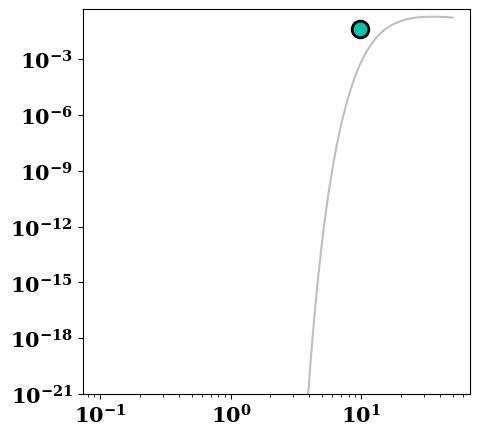

In [31]:
fig, ax = plt.subplots(figsize=(5,5))

Fcalc = data_plotint['F_peak']#[0:100:2]
nucalc = data_plotint['nu_peak']#[0:100:2]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    ax.plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)

#Overplot the data:
#ax.errorbar(6.05,0.0318,0.0095,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
#ax.plot(9.02,0.0258, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
#ax.errorbar(14.75,0.0155, 0.0056,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)
ax.errorbar(9.77,0.0405,0.0078,fmt ='o',color='xkcd:turquoise',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-21,0.5)
#ax.set_xlim(1,18)

In [32]:
#nu_sed,SSA_FFA_sed
from scipy.interpolate import interp1d
SSA_FFA_sed[np.where(nu_sed > 9.77)]

# Create an interpolation function
interp_func = interp1d(nu_sed,SSA_FFA_sed, kind='linear')

# Extract the flux value at 9.77 GHz
flux_at_9p77 = interp_func(9.77)

flux_at_9p77 # 4.40992826e-12 mJy for 4.33 mJy case, 6.54065278e-12 mJy for 1.07mJy case, 4.2466405e-33 mJy for 10mJy case
#5.3e-4mJy

array(0.00053604)

Text(0, 0.5, '$F_{peak}$ (mJy)')

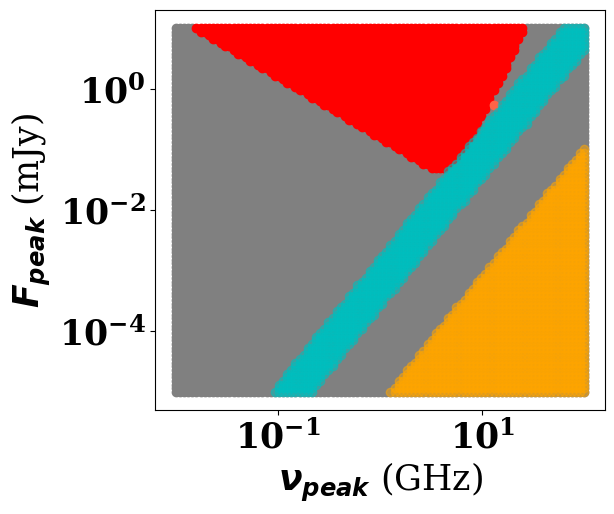

In [30]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('font', weight='bold')
plt.figure(figsize=(5.80,5.20))

plt.plot(nucalca,Fcalca,'o',color='gray')#,label='allowed SED')
plt.plot(nucalcb,Fcalcb,'o',color='red',label='Not allowed SED')
plt.plot(data_plotint['nu_peak'],data_plotint['F_peak'],'o',color='tomato',label=r'new')
#plt.plot(nucalcd,Fcalcd,'o',color='pink',label='v = R/t > 2e4 km/s')
#plt.plot(nucalce,Fcalce,'.',color='green',alpha=0.2,label='v = R/t < 1500 km/s')
#plt.plot(nucalcf,Fcalcf,'o',color='yellow',alpha=0.5,label='3e15 < Radius < 2e16 cm')
plt.plot(nucalcc,Fcalcc,'o',color='orange',alpha=0.5,label='Radius < 4e15 cm')
plt.plot(nucalch,Fcalch,'o',color='c',alpha=0.5,label='Radius < 5e16 cm')
#Add label
#plt.text(0.1,5,r'Ruled out by radio', color='k')
#plt.text(0.1,3,r'upper limits',color='k')

#plt.text(1, 1e-4, r'$R_{CSM}$ $< 2\times10^{16} cm$', color='k',rotation=50, rotation_mode='anchor')
#plt.text(10, 1e-4, r'$R_{CSM}$ $< 3.5\times10^{15} cm$', color='k',rotation=50, rotation_mode='anchor')
#plt.text(1.5e-2, 1, r'$v > c$', color='k',rotation=50, rotation_mode='anchor')
#plt.text(2e-2, 1e-3, r'$v > 2\times10^{4}$ $km$ $s^{-1}$', color='k',rotation=50, rotation_mode='anchor')
#plt.text(8e-1, 4e-4, r'$R_{CSM}$ $< 5\times10^{16} cm$', color='k',rotation=50, rotation_mode='anchor')

plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize = 25)
plt.xlabel(r'$\nu_{peak}$ (GHz)',fontsize=25)
plt.ylabel(r'$F_{peak}$ (mJy)',fontsize=25)
#plt.savefig('flux-freq-limit.png',bbox_inches='tight',dpi = 500, transparent = True)
#plt.legend()

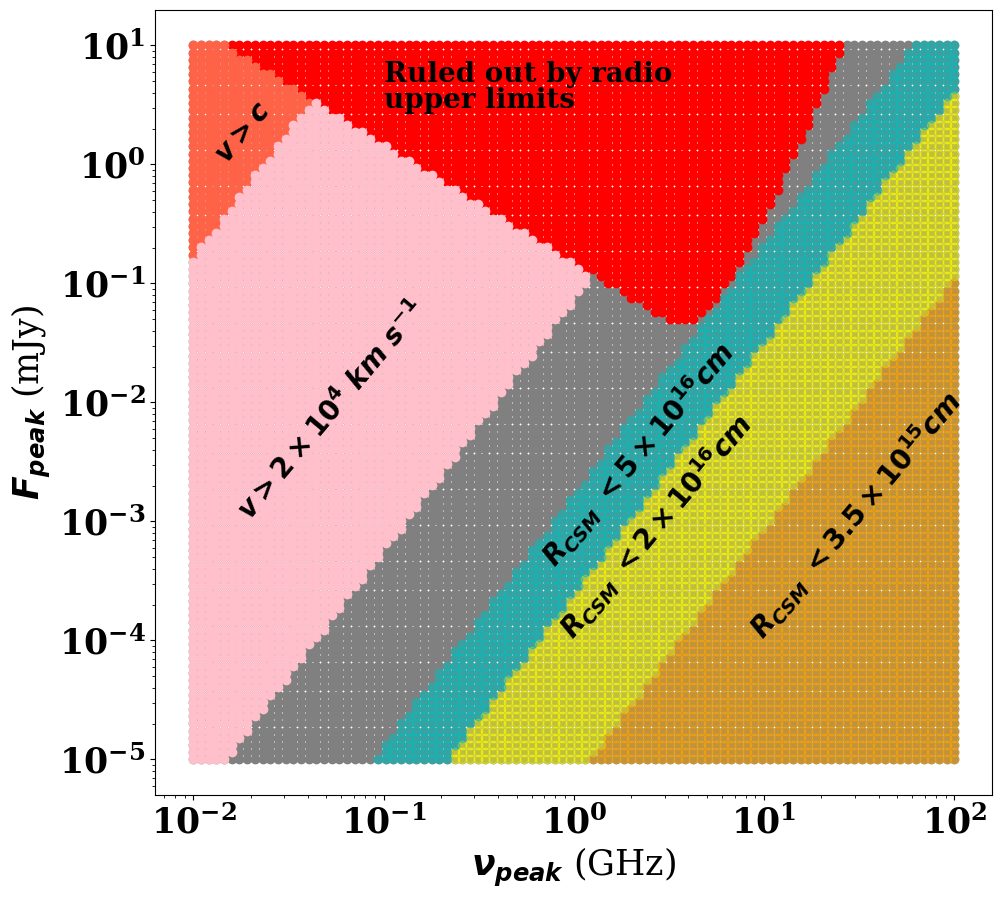

In [64]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('font', weight='bold')
plt.figure(figsize=(10.80,10.20))

plt.plot(nucalca,Fcalca,'o',color='gray')#,label='allowed SED')
plt.plot(nucalcb,Fcalcb,'o',color='red',label='Not allowed SED')
plt.plot(nucalcg,Fcalcg,'o',color='tomato',label=r'v = R/t > speed of light')
plt.plot(nucalcd,Fcalcd,'o',color='pink',label='v = R/t > 2e4 km/s')
#plt.plot(nucalce,Fcalce,'.',color='green',alpha=0.2,label='v = R/t < 1500 km/s')
plt.plot(nucalcf,Fcalcf,'o',color='yellow',alpha=0.5,label='3e15 < Radius < 2e16 cm')
plt.plot(nucalcc,Fcalcc,'o',color='orange',alpha=0.5,label='Radius < 4e15 cm')
plt.plot(nucalch,Fcalch,'o',color='c',alpha=0.5,label='Radius < 5e16 cm')
#Add label
plt.text(0.1,5,r'Ruled out by radio', color='k')
plt.text(0.1,3,r'upper limits',color='k')

plt.text(1, 1e-4, r'$R_{CSM}$ $< 2\times10^{16} cm$', color='k',rotation=50, rotation_mode='anchor')
plt.text(10, 1e-4, r'$R_{CSM}$ $< 3.5\times10^{15} cm$', color='k',rotation=50, rotation_mode='anchor')
plt.text(1.5e-2, 1, r'$v > c$', color='k',rotation=50, rotation_mode='anchor')
plt.text(2e-2, 1e-3, r'$v > 2\times10^{4}$ $km$ $s^{-1}$', color='k',rotation=50, rotation_mode='anchor')
plt.text(8e-1, 4e-4, r'$R_{CSM}$ $< 5\times10^{16} cm$', color='k',rotation=50, rotation_mode='anchor')

plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize = 25)
plt.xlabel(r'$\nu_{peak}$ (GHz)',fontsize=25)
plt.ylabel(r'$F_{peak}$ (mJy)',fontsize=25)
plt.savefig('flux-freq-limit.png',bbox_inches='tight',dpi = 500, transparent = True)
#plt.legend()

In [7]:
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
indexb = np.where(data_plot['RuledOut'] == 'True')[0]
data_plotb = data_plot[indexb]
indexc = np.where(data_plota['Radius'] < 35.8401e14)[0] #based on allowed SED
data_plotc = data_plota[indexc]
indexd = np.where((data_plota['v_shock'] > 2e4) & (data_plota['v_shock'] < 3e6))[0] #based on allowed sed
data_plotd = data_plota[indexd]
indexe = np.where(data_plota['v_shock'] < 1500)[0] #based on allowed sed
data_plote = data_plota[indexe]
indexf = np.where((data_plota['Radius'] < 2e16) & (data_plota['Radius'] > 35.8401e14))[0] #based on allowed SED
data_plotf = data_plota[indexf]

indexg = np.where(data_plota['v_shock'] > 3e6)[0] #based on allowed SED
data_plotg = data_plota[indexg]
indexh = np.where((data_plota['Radius'] > 2e16) & (data_plota['Radius'] < 5e16) )[0] #based on theoretical estimation
data_ploth = data_plota[indexh]

v1 = data_plota['v_shock']
M1 = data_plota['Mdot']*1e-5
v2 = data_plotb['v_shock']
M2 = data_plotb['Mdot']*1e-5
v3 = data_plotc['v_shock']
M3 = data_plotc['Mdot']*1e-5

v4 = data_plotd['v_shock']
M4 = data_plotd['Mdot']*1e-5

v5 = data_plote['v_shock']
M5 = data_plote['Mdot']*1e-5

v6 = data_plotf['v_shock']
M6 = data_plotf['Mdot']*1e-5
v7 = data_plotg['v_shock']
M7 = data_plotg['Mdot']*1e-5

v8 = data_ploth['v_shock']
M8 = data_ploth['Mdot']*1e-5

In [10]:

d1 = data_plota['den']
R1 = data_plota['Radius']

d2 = data_plotb['den']
R2 = data_plotb['Radius']

d3 = data_plotc['den']
R3 = data_plotc['Radius']

d4 = data_plotd['den']
R4 = data_plotd['Radius']

d6 = data_plotf['den']
R6 = data_plotf['Radius']

d7 = data_plotg['den']
R7 = data_plotg['Radius']

d8 = data_ploth['den']
R8 = data_ploth['Radius']
#indextest = np.where(data_plotg != d1)
#data_plota[indextest]

Text(0, 0.5, '$\\rho_{CSM}$ (g cm$^{-3}$)')

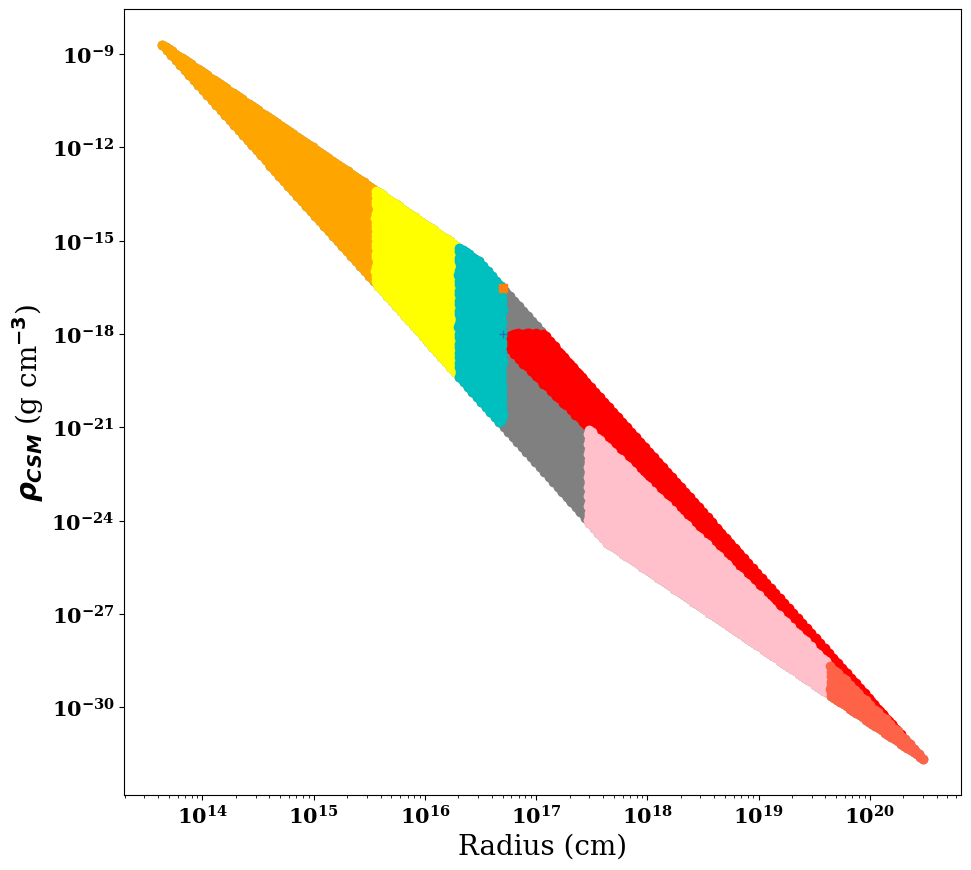

In [11]:
plt.figure(1, figsize=(10.80,10.20))
plt.plot(R1,d1,'o',color='gray')
plt.plot(R2,d2,'o',color='red')
plt.plot(R3,d3,'o',color='orange')
plt.plot(R4,d4,'o',color='pink')
plt.plot(R6,d6,'o',color='yellow')
plt.plot(R7,d7,'o',color='tomato')
plt.plot(R8,d8,'o',color='c')
plt.plot(5e16,1e-18,'+')
plt.plot(5e16,3e-17,'s')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Radius (cm)',fontsize=20)
plt.ylabel(r'$\rho_{CSM}$ (g cm$^{-3}$)',fontsize=20) # V (= R/t km/s).

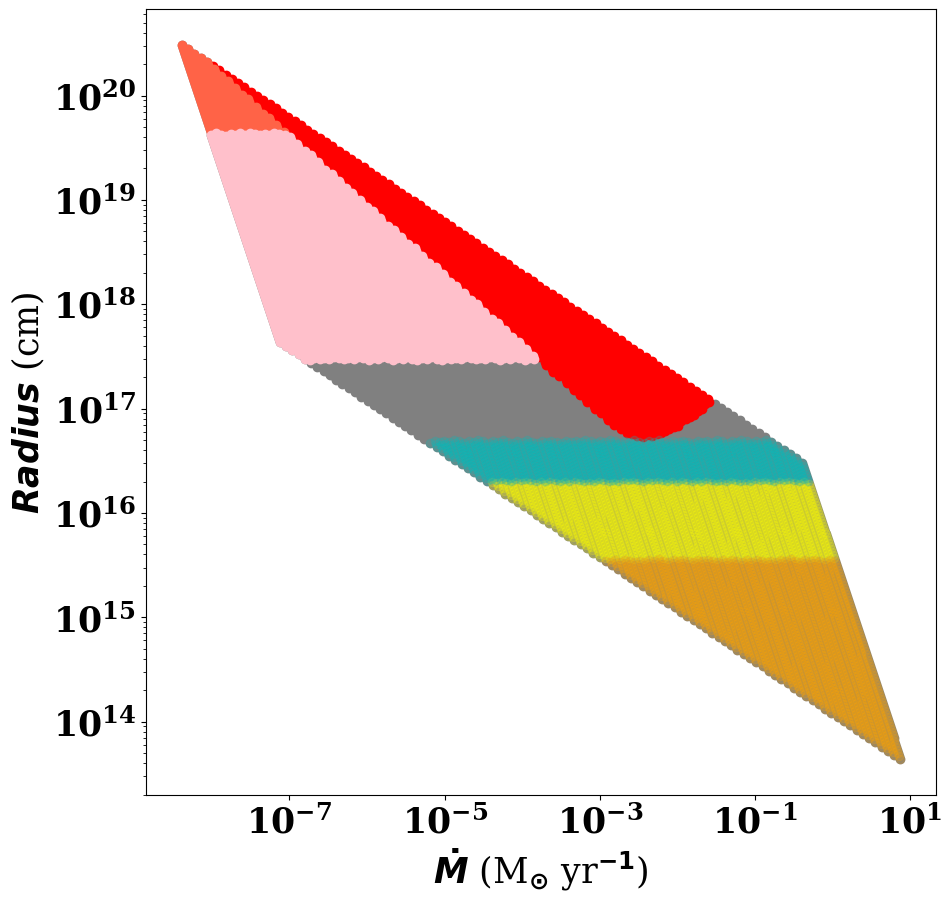

In [12]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(10.20,10.20))
plt.figure(1, figsize=(10.80,10.20))

plt.plot(M1,R1,'o',color='gray')#,label='allowed SED')
plt.plot(M2,R2,'o',color='red',label='Ruled out SED')
plt.plot(M7,R7,'o',color='tomato',label=r'v = R/t > speed of light')
plt.plot(M4,R4,'o',color='pink',label=r'v = R/t > 2 $\times$ $10^{4}$ km/s')
#plt.plot(M5,v5,'.',color='green',alpha=0.2,label='v = R/t < 1500 km/s')
plt.plot(M6,R6,'o',color='yellow',alpha=0.2,label=r'3 $\times$ $10^{15}$ < $R_{CSM}$ < 2 $\times$ $10^{16}$ cm')
plt.plot(M3,R3,'o',color='orange',alpha=0.2,label=r'$R_{CSM}$ < 4 $\times$ $10^{15}$ cm')
plt.plot(M8,R8,'o',color='c',alpha=0.2,label=r'$R_{CSM}$ < 5 $\times$ $10^{16}$ cm')

plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize = 25)
#plt.xlabel(r'$\.{M}$ $\times 10^{-5}$(M$_{\odot}$ yr$^{-1}$)',fontsize=25)
plt.xlabel(r'$\.{M}$ (M$_{\odot}$ yr$^{-1}$)',fontsize=25)
plt.ylabel(r'$Radius$ (cm)',fontsize=25) # V (= R/t km/s).

#plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
#plt.grid(True)
#plt.legend(fontsize = 10)
plt.savefig('R-Mdot-limit.png',bbox_inches='tight',dpi = 500, transparent = True)

Text(0.5, 0, '$R_{CSM}$ (cm)')

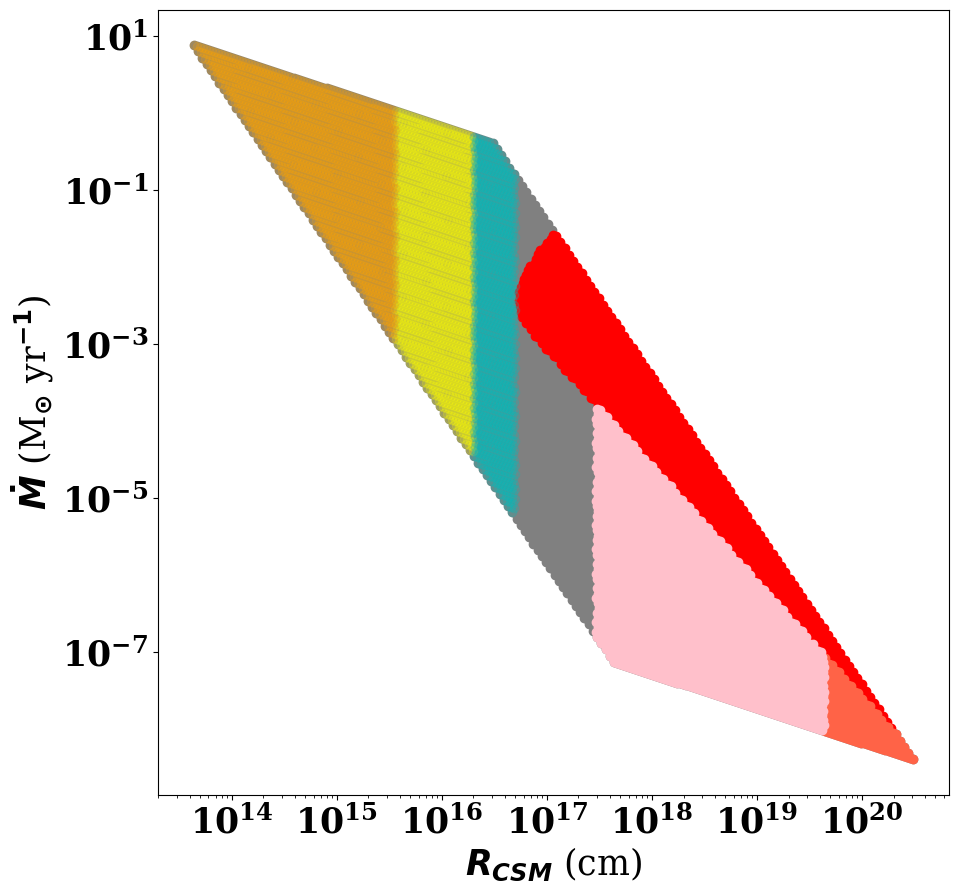

In [13]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(10.20,10.20))
plt.figure(1, figsize=(10.80,10.20))

plt.plot(R1,M1,'o',color='gray')#,label='allowed SED')
plt.plot(R2,M2,'o',color='red',label='Ruled out SED')
plt.plot(R7,M7,'o',color='tomato',label=r'v = R/t > speed of light')
plt.plot(R4,M4,'o',color='pink',label=r'v = R/t > 2 $\times$ $10^{4}$ km/s')
#plt.plot(M5,v5,'.',color='green',alpha=0.2,label='v = R/t < 1500 km/s')
plt.plot(R6,M6,'o',color='yellow',alpha=0.2,label=r'3 $\times$ $10^{15}$ < $R_{CSM}$ < 2 $\times$ $10^{16}$ cm')
plt.plot(R3,M3,'o',color='orange',alpha=0.2,label=r'$R_{CSM}$ < 4 $\times$ $10^{15}$ cm')
plt.plot(R8,M8,'o',color='c',alpha=0.2,label=r'$R_{CSM}$ < 5 $\times$ $10^{16}$ cm')

plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize = 25)
#plt.xlabel(r'$\.{M}$ $\times 10^{-5}$(M$_{\odot}$ yr$^{-1}$)',fontsize=25)
plt.ylabel(r'$\.{M}$ (M$_{\odot}$ yr$^{-1}$)',fontsize=25)
plt.xlabel(r'$R_{CSM}$ (cm)',fontsize=25) # V (= R/t km/s).

#plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
#plt.grid(True)
#plt.legend(fontsize = 10)
#plt.savefig('v-Mdot-limit.png',bbox_inches='tight',dpi = 500, transparent = True)

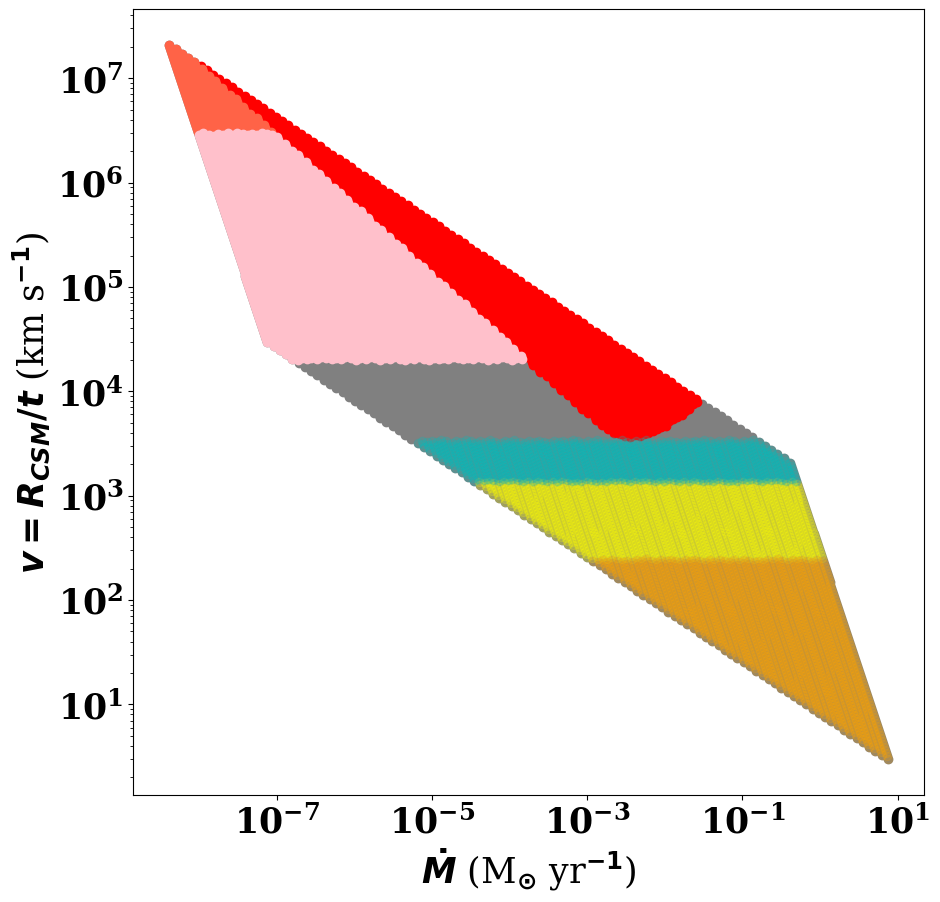

In [68]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(10.20,10.20))
plt.figure(1, figsize=(10.80,10.20))

plt.plot(M1,v1,'o',color='gray')#,label='allowed SED')
plt.plot(M2,v2,'o',color='red',label='Ruled out SED')
plt.plot(M7,v7,'o',color='tomato',label=r'v = R/t > speed of light')
plt.plot(M4,v4,'o',color='pink',label=r'v = R/t > 2 $\times$ $10^{4}$ km/s')
#plt.plot(M5,v5,'.',color='green',alpha=0.2,label='v = R/t < 1500 km/s')
plt.plot(M6,v6,'o',color='yellow',alpha=0.2,label=r'3 $\times$ $10^{15}$ < $R_{CSM}$ < 2 $\times$ $10^{16}$ cm')
plt.plot(M3,v3,'o',color='orange',alpha=0.2,label=r'$R_{CSM}$ < 4 $\times$ $10^{15}$ cm')
plt.plot(M8,v8,'o',color='c',alpha=0.2,label=r'$R_{CSM}$ < 5 $\times$ $10^{16}$ cm')

plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize = 25)
#plt.xlabel(r'$\.{M}$ $\times 10^{-5}$(M$_{\odot}$ yr$^{-1}$)',fontsize=25)
plt.xlabel(r'$\.{M}$ (M$_{\odot}$ yr$^{-1}$)',fontsize=25)
plt.ylabel(r'$v = R_{CSM}/t$ (km s$^{-1}$)',fontsize=25) # V (= R/t km/s).

#plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
#plt.grid(True)
#plt.legend(fontsize = 10)
plt.savefig('v-Mdot-limit.png',bbox_inches='tight',dpi = 500, transparent = True)